In [68]:
# BMEN 415 | Group 2 | Huzefa Ansari, Amina Saleh, Jenny Hua, Lauren Wentzel | Winter 2023 
# Final project | Image Classification Dataset

# Import Programs
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import glob
import os
from pathlib import Path
import cv2
from PIL import Image

# Import Modules from Keras to Facilitate Modeling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout,Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from keras import backend as K
%matplotlib inline

In [69]:
# Function to Sort Through Training Data

def sortTrainingData():
    normalData = trainingFolder/"NORMAL" # Specify data with Normal Patients
    pneumoniaData = trainingFolder/"PNEUMONIA" # Specify data obtained from Patients with Pneumonia
    normalImages = normalData.glob("*.jpeg")  # # Locate all image files in the Normal Subsection
    pneumoniaImages = pneumoniaData.glob("*.jpeg") # Locate all image files in the Pneumonia Subsection
    trainingData = [] # Create data Array
    trainingLabels = [] # Create label Array
    for img in normalImages: # If data is normal, append the word 'NORMAL' to the corresponding image indices
        trainingData.append(img)
        trainingLabels.append("NORMAL") 
    for img in pneumoniaImages: # If pneumonia data, append the word 'PNEUMONIA' to the corresponding image indices
        trainingData.append(img)
        trainingLabels.append("PNEUMONIA")
    data = pd.DataFrame(trainingData) # Reshape the training data images
    data.columns = ["images"] # Assign the columns as the images from the training dataset
    data["labels"] = trainingLabels # Assign labels to ensure each image is associated to the corresponding label
    return data

In [70]:
# Fucntion to sift through Testing Data

def sortTestingData(isVal = True):
    normalData = testingFolder/"NORMAL" # Specify data with Normal Patients
    pneumoniaData = testingFolder/"PNEUMONIA"  # Specify data obtained from Patients with Pneumonia
    normalImages = normalData.glob("*.jpeg") # Locate all image files in the Normal Subsection
    pneumoniaImages = pneumoniaData.glob("*.jpeg") # Locate all image files in the Pneumonia Subsection
    data = [] # Create Data array
    labels = [] # Create Label Array
    def prepare(case): # Prepare the data in regards to shape, image and size
        for img in case:
            img = cv2.imread(str(img)) # Read the Image as a String
            img = cv2.resize(img, (224, 224)) # Resize the image to 224x224
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Identify the colors within the image
            img = img.astype(np.float32)/255.
            if case == normalImages:
                label = to_categorical(0, num_classes=2) # If image is deemed 'normal', assign it to category 1: normal
            else:
                label = to_categorical(1, num_classes=2) # If image is deemed 'pneumonia', assign it to category 1: pneumonia
            data.append(img) # Append Images to one Array
            labels.append(label) # Append Labels to one Array
        return data, labels
    prepare(normalImages) 
    testData, testLabels = prepare(pneumoniaImages) 
    test_Data = np.array(testData) # Shape/quanitfy the data to one array
    test_Labels = np.array(testLabels) # Shape/quantify the labels to one array 
    return test_Data, test_Labels # Return Images and Data as seperate arrays

In [71]:
# Curate the Data for use in the Model 
    
def dataCuration(data, batchSize): 
    n = len(data)
    numberOfBatches = n//batchSize # Identify the number of batches based on the number provided to the function
    
    batchData = np.zeros((batchSize, 224, 224, 3), dtype=np.float32) # Create a sized matrix for the data per batch
    batchLabels = np.zeros((batchSize, 2), dtype=np.float32) # Create a sized matrix for the labels per batch
    
    indices = np.arange(n) # Arrange the indices in ascending order
    
    i=0 
    
    while True:
        np.random.shuffle(indices) # Shuffle the indices
        count = 0
        nextBatch = indices[(i * batchSize):(i+1)*batchSize] # Select which batch is being curated
        for j, idx in enumerate(nextBatch):
            imgName = data.iloc[idx]["images"] # Identify the Image
            label = data.iloc[idx]["labels"] # Label the Image
            if label == "NORMAL": # Normal Images are Assigned an Index of 0
                label = 0 
            else: # Pneumonia Images are assigned an index of 1
                label = 1
            encodedLabel = to_categorical(label, num_classes=2) # Encode labels based on the categories assigned above
            img = cv2.imread(str(imgName)) # Read the file
            img = cv2.resize(img, (224, 224)) # Reshape the file
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
                
            origImage = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Analyze the color of the image
            origImage = img.astype(np.float32)/255.
            
            batchData[count] = origImage # Append the image based on the counter and batch
            batchLabels[count] = encodedLabel # Append the label based on the counter and the batcg
            
            count += 1
            
            if count == batchSize - 1: 
                break
        i += 1
        
        yield batchData, batchLabels # Return Data and Labels for each Batch
        
        if i >= numberOfBatches: 
            i=0

In [72]:
# Locate File and Directories

print (os.path.abspath("chest_xray")) # Locate File
dataFile = Path('/Users/aminasaleh/Downloads/chest_xray/') # Specify File Location
print(os.listdir(dataDirectory)) # Find the Directories in the Files

trainingFolder = dataFile/"train" # Identify Training Folder
testingFolder = dataFile/"test" # Idenitfy Testing Folder

/Users/aminasaleh/BMEN 415/chest_xray
['.DS_Store', 'test', 'train']


In [73]:
#Sort Data

modelTraining = sortTrainingData() # Call Function to Sort the Training Data
testData, testLabels = sortTestingData(isVal=False)  # Call Function to Sort/Shape the Testing Data

In [74]:
# Establish the Sequential model from Keras

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(2))
model.add(Activation("softmax"))

# Summarize the Model Parameters

model.summary ()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_15 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_16 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                 

In [75]:
# Train the Dataset Based on the Data

batchSize = 16 # Specify the batch Size
numberOfEpochs = 3 # Specify the number of Epochs
curatedTrainingData = dataCuration(trainData, batchSize) # Curate the training Data based on Batch Size

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) # Compile the Model

modelFit = model.fit(curatedTrainingData, epochs=numberOfEpochs, steps_per_epoch = (trainData.shape[0]//batchSize)) # Fit the Model to the Training Data

Epoch 1/3
326/326 [==============================] - 158s 481ms/step - loss: 0.2124 - accuracy: 0.8733
Epoch 2/3
326/326 [==============================] - 163s 499ms/step - loss: 0.0994 - accuracy: 0.9195
Epoch 3/3
326/326 [==============================] - 176s 539ms/step - loss: 0.0602 - accuracy: 0.9156


39/39 [==============================] - 5s 114ms/step
              precision    recall  f1-score   support

           0       1.00      0.14      0.25       234
           1       0.66      1.00      0.80       390

    accuracy                           0.68       624
   macro avg       0.83      0.57      0.52       624
weighted avg       0.79      0.68      0.59       624

[[ 33 201]
 [  0 390]]
The Accuracy Score for the Sequential Model is: 0.67788


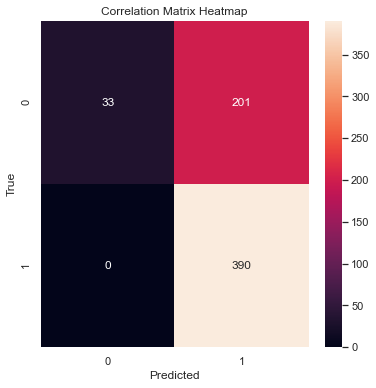

In [93]:
# Predict the Outcome and Specify The Accuracy Metrics

prediction = model.predict(testData, batch_size=16) # Predict the Data with the Batch Sizes and test Data
prediction = np.argmax(prediction, axis=-1) # Predict the labels for the data above 
labels = np.argmax(testLabels, axis=-1) # Asssign the labels to an independent array

# Confusion Matrix 
conf_mat = confusion_matrix(labels, prediction)
heatmap = sns.heatmap(conf_mat, annot=True, fmt='.0f')

sns.set(font_scale=1.2)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set(rc={'figure.figsize':(6,6)})
sns.set_palette("pastel")
plt.title('Correlation Matrix Heatmap')

heatmap.set_xlabel('Predicted')
heatmap.set_ylabel('True')

#Display the Accuracy Metrics

print(classification_report(labels, prediction))
print(confusion_matrix(labels, prediction))
print("The Accuracy Score for the Sequential Model is:", round((accuracy_score(labels, prediction)),5))